In [1]:
!pip install -U torch torchvision cython
!pip install pycocotools

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/5c/01/5ab75f138bf32d7a69df61e4997e24eccad87cc009f5fb7e2a31af8a4036/torch-2.2.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/c6/75/d869f600fc33df8b8ca99943e165a4ca23b73c68dc1942098fde0a6b46f3/torchvision-0.17.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cython from https://files.pythonhosted.org/packages/18/ec/f47a721071d084d6c2b6783eb8d058b964b1450cb708d920d0d792f42001/Cython-3.0.10-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/01/f3/936e209267d6ef7510322191003885de524fc48d1b43269810cd589ceaf5/typing_extensions-4.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/198.6 MB 4.3 MB/s eta 0:00

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
torchaudio 2.2.1 requires torch==2.2.1, but you have torch 2.2.2 which is incompatible.


  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/24/b2/ef28a34cf6ca50b6b2f7ad81e5837ed45c252ffef22f5a704b94141ea842/pycocotools-2.0.7-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/85.8 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.8 kB ? eta -:--:--
   ---------------------------- ----------- 61.4/85.8 kB 656.4 kB/s eta 0:00:01
   ---------------------------------------- 85.8/85.8 kB 803.6 kB/s eta 0:00:00


## Data Loading and Unzip

In [2]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q train2017.zip
!unzip -q annotations_trainval2017.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Data Subset Creation

In [ ]:
import json
import shutil

# Load the COCO class names
with open(r"coco.names", 'r') as file:
    classes = file.read().strip().split('\n')

# Indices for vehicle-related classes in COCO dataset (you'll need to verify these)
vehicle_classes = ['person','bicycle','car','motorbike','aeroplane','bus','train','truck','boat','traffic light','fire hydrant','stop sign','parking meter','bench','bird']
vehicle_indices = [classes.index(cls) for cls in vehicle_classes if cls in classes]

# Load the annotations
annotations_path = r"Your file path for Annotations file"
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Find the image ids for images that contain vehicle-related classes
vehicle_image_ids = set()
for ann in annotations['annotations']:
    if ann['category_id'] in vehicle_indices:
        vehicle_image_ids.add(ann['image_id'])
# Now filter the images and copy them to a new directory
filtered_image_dir = r"File path to save the filtered images"
os.makedirs(filtered_image_dir, exist_ok=True)

for img in annotations['images']:
    if img['id'] in vehicle_image_ids:
        # Correct the path here to match your Windows directory structure
        source_img_path = f"Your file path for coco image dataset "
        dest_img_path = f"{filtered_image_dir}\\{img['file_name']}"
        shutil.copy(source_img_path, dest_img_path)

In [26]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
import torch
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

# Define the transformation
def get_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(0.5),
    ])

# transform = transforms.Compose([
#     transforms.Resize((IMG_WIDTH, IMG_HEIGHT))
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

class FilteredCocoDetection(CocoDetection):
    def __init__(self, root, annFile, transform=None, max_imgs=None):
        super(FilteredCocoDetection, self).__init__(root, annFile, transform=transform)
        with open(annFile, 'r') as f:
            cat_data = json.load(f)
            cat_ids = {x['id']: x['name'] for x in cat_data['categories']}
            selected_cats = ['person', 'bicycle', 'car', 'motorbike', 'bus', 'train', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter']
            self.cat_mapping = {cid: idx + 1 for idx, cid in enumerate([cid for cid, name in cat_ids.items() if name in selected_cats])}
            
        self.ids = [img_id for img_id in self.ids if len(self.coco.getAnnIds(imgIds=img_id, catIds=list(self.cat_mapping.keys()))) > 0]
        self.ids = self.ids[:max_imgs] if max_imgs is not None else self.ids

    def __getitem__(self, index):
        img, target = super(FilteredCocoDetection, self).__getitem__(index)
        annotations = [t for t in target if t['category_id'] in self.cat_mapping]

        # Process boxes
        boxes = torch.as_tensor([t['bbox'] for t in annotations], dtype=torch.float32)
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  # x_max = x_min + width
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  # y_max = y_min + height
        
        valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
        if not valid_boxes.all():
            print(f"Correcting invalid boxes in image index {index}")
            boxes = boxes[valid_boxes]

        labels = torch.tensor([self.cat_mapping[t['category_id']] for t in annotations], dtype=torch.int64)
        labels = labels[valid_boxes]  # Only keep labels with valid boxes

        if boxes.shape[0] == 0:
            raise ValueError(f"No valid boxes after correction for image index {index}")

        target_dict = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index])}
        return img, target_dict
        
        # print(img,target)

def check_data(dataset):
    for i in range(len(dataset)):
        _, target = dataset[i]
        boxes = target['boxes']
        labels = target['labels']

        if not torch.all(boxes[:, 2:] > boxes[:, :2]):
            print(f"Invalid box found in image index {i}: {boxes}")
        if torch.any(boxes <= 0):
            print(f"Non-positive dimensions found in image index {i}: {boxes}")
        if torch.any(torch.isnan(boxes) | torch.isinf(boxes)):
            print(f"NaN or inf values found in boxes in image index {i}")
        if not len(labels) == boxes.size(0):
            print(f"Mismatch between number of boxes and labels in image index {i}")
# Initialize the dataset
train_dataset = FilteredCocoDetection('./train2017', './annotations/instances_train2017.json', transform=get_transform(), max_imgs=30_000)
val_dataset = FilteredCocoDetection('./train2017', './annotations/instances_train2017.json', transform=get_transform(), max_imgs=30_000)


def collate_fn(batch):
    return tuple(zip(*batch))


loading annotations into memory...
Done (t=16.81s)
creating index...
index created!
loading annotations into memory...
Done (t=15.08s)
creating index...
index created!


## Version 1

In [4]:
# def get_model(num_classes):
#     # Load a pre-trained model
# #     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
#     backbone = resnet_fpn_backbone('resnet50', pretrained=True)
#     anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.5, 1.0, 2.0))

#     # Replace the classifier with a new one, that has num_classes which is user-defined
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     return model

# # Adjust num_classes to be one more than your categories because of the background class
# model = get_model(len(train_dataset.cat_mapping) + 1)


## Version 2

In [5]:
# num_classes = len(selected_cats) + 1  # number of classes + background

# backbone = resnet_fpn_backbone('resnet50', pretrained=True)

# anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.5, 1.0, 2.0))
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['O'], output_size=7, sampling_ratio=2)
# rpn_head = RPNHead(backbone.out_channels, anchor_generator.num_anchors_per_location()[0])
# rpn = RegionProposalNetwork(anchor_generator, rpn_head, fg_iou_thresh=0.7, bg_iou_thresh=0.3,
#                             batch_size_per_image=256, positive_fraction=0.5,
#                             pre_nms_top_n={'training': 2000, 'testing': 1000},
#                             post_nms_top_n={'training': 2000, 'testing': 1000},
#                             nms_thresh=0.7)

## Working Right Now

In [27]:
# # Adjust the number of classes in the model
# selected_cats = ['person', 'bicycle', 'car', 'motorbike', 'bus', 'train', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter']

# num_classes = len(selected_cats) + 1  # number of classes + background
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# # model=FasterRCNN(backbone,num_classes=num_classes,rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

# in_features = model.roi_heads.box_predictor.cls_score.in_features



# # Create the Faster R-CNN model using the ResNet backbone with FPN and the custom RPN
# # model = FasterRCNN(backbone, num_classes=num_classes, rpn=rpn) 

# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)


## Creating Faster-RCNN Model (Includes RPN)

In [28]:
# Adjust the number of classes in the model
selected_cats = ['person', 'bicycle', 'car', 'motorbike', 'bus', 'train', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter']
num_classes = len(selected_cats) + 1  # number of classes + background

def create_model(num_classes):
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)

    anchor_generator = AnchorGenerator(sizes=((32,),(64,),(128,),(256,),(512,)), 
                                        aspect_ratios=((0.5, 1.0, 2.0),)*5)

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0','1','2','3'], 
        output_size=7, 
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )
    return model
model=create_model(num_classes=num_classes)
print(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)

## Training Loop

In [ ]:
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm
def save_model(model, save_path):
    # Create directory if it doesn't exist
    # os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # Save the entire model
    torch.save(model, save_path)
    print(f"Model saved to {save_path}")

def save_model_state(model, save_path):
    # Create directory if it doesn't exist
    # os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # Save only the state dictionary
    torch.save(model.state_dict(), save_path)
    print(f"Model state dictionary saved to {save_path}")
    
def evaluate_model(model, data_loader, device, iou_thresholds=(0.5,)):
    model.eval()
    all_ious = {iou_th: [] for iou_th in iou_thresholds}
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            for i, output in enumerate(outputs):
                pred_boxes = output['boxes']
                pred_scores = output['scores']
                gt_boxes = targets[i]['boxes']
                
                # Calculate IoU for each predicted box with ground truth boxes
                ious = torchvision.ops.box_iou(gt_boxes, pred_boxes)
                
                for iou_th in iou_thresholds:
                    matched_indices = (ious >= iou_th).any(dim=1)
                    matched_ious = ious.max(dim=1)[0]
                    
                    true_positives = matched_indices.sum().item()
                    false_negatives = (matched_indices.sum(dim=0) == 0).sum().item()
                    false_positives = len(pred_boxes) - true_positives
                    
                    precision = true_positives / (true_positives + false_positives)
                    recall = true_positives / (true_positives + false_negatives)
                    
                    all_ious[iou_th].extend(matched_ious.cpu().numpy())
                    
                all_predictions.extend(pred_boxes.cpu().numpy())
                all_targets.extend(gt_boxes.cpu().numpy())
    
    # Compute mAP for each IoU threshold
    mAPs = {}
    for iou_th in iou_thresholds:
        iou_values = all_ious[iou_th]
        precision, recall, _ = sklearn.metrics.precision_recall_curve(
            np.ones_like(iou_values), iou_values)
        average_precision = sklearn.metrics.average_precision_score(
            np.ones_like(iou_values), iou_values)
        mAPs[f"mAP@{iou_th}"] = average_precision
    
    # Compute overall mAP
    overall_mAP = np.mean(list(mAPs.values()))
    
    return overall_mAP, mAPs

def plot_loss(loss_list):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_list, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

def main():
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=min(1, len(train_dataset)), shuffle=True, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=min(1, len(val_dataset)), shuffle=False, collate_fn=collate_fn)

    # Parameters and optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)

    num_epochs = 5  # Set the number of epochs
    loss_list1 = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for idx, (images, targets) in enumerate(train_loader):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            
            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
            optimizer.step()
            running_loss += losses.item()
            
            
            del images
            del targets

            if (idx+1)%1000 == 0:
                print(f"Epoch: {epoch+1}, Batch: {idx+1}, Loss: {running_loss / (idx+1)}")
                loss_list1.append(running_loss / (idx+1))

        print(f"Epoch: {epoch+1}, Loss: {losses.item()}")
    save_model_state(model, "trained_model_3.pth")
    print(loss_list1)
    # Evaluate the model
    overall_mAP, mAPs = evaluate_model(model, val_loader, device, iou_thresholds=(0.5, 0.75, 0.9))

    print(f'Overall mAP: {overall_mAP:.4f}')
    for iou_th, mAP in mAPs.items():
        print(f'{iou_th}: {mAP:.4f}')
    # Plot training loss
#     plot_loss(loss_list1)
if __name__ == "__main__":
    main()

## Testing the model

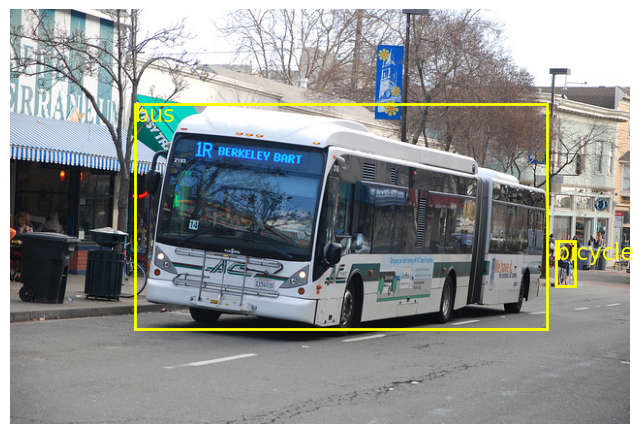

In [23]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define the classes again if necessary
selected_cats = ['person', 'bicycle', 'car', 'motorbike', 'bus', 'train', 'truck', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter']

def load_image(image_path):
    return Image.open(image_path).convert("RGB")

def preprocess_image(image):
    transform = T.Compose([T.ToTensor()])
    return transform(image).unsqueeze(0)

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def load_model(saved_model_path, num_classes):
    # Load the pre-trained model architecture
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    
    # Replace the classifier with a new one, matching the number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Load the state dictionary
    model.load_state_dict(torch.load(saved_model_path))
    
    return model


def postprocess_output(output, threshold=0.8):
    boxes = output['boxes'].detach().cpu().numpy()
    scores = output['scores'].detach().cpu().numpy()
    labels = output['labels'].detach().cpu().numpy()
    boxes = boxes[scores >= threshold].astype(np.int32)
    labels = labels[scores >= threshold]
    return boxes, labels

def visualize_results(image, boxes, labels):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    ax = plt.gca()
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        box_width = xmax - xmin
        box_height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), box_width, box_height, fill=False, edgecolor='yellow', linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin, selected_cats[label], fontsize=16, color='yellow', verticalalignment='top')
    plt.axis('off')
    plt.show()

def main():
    # Load the saved model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    saved_model_path = "trained_model.pth"
    num_classes = len(selected_cats) + 1  # number of classes + background
    model = load_model(saved_model_path, num_classes)
    model.to(device)
    model.eval()

    # Load a single image for inference
    image_path = r"Test Image path"
    image = load_image(image_path)
    input_image = preprocess_image(image).to(device)

    # Perform inference on the single image
    with torch.no_grad():
        output = model(input_image)

    # Post-process the output and visualize the results
    boxes, labels = postprocess_output(output[0])
    visualize_results(np.array(image), boxes, labels)

if __name__ == "__main__":
    main()